In [4]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [5]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


In [6]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

100%|██████████| 9.91M/9.91M [00:00<00:00, 38.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.06MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 9.66MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.49MB/s]


In [7]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


Architecture

In [8]:
class Model_2(nn.Module):
    def __init__(self, drop=0.025):
        super(Model_2, self).__init__()
        # Input Block
        self.pool = nn.MaxPool2d(2, 2) # output_size = 12    RF:  6

        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.Dropout(drop)
        ) 

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),  
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout(drop)
        ) 


        # TRANSITION BLOCK 1
        self.trans1 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=4, kernel_size=(1, 1), bias=False),
            nn.BatchNorm2d(4),
            nn.ReLU(),
            nn.Dropout(drop)
        ) 

        # CONVOLUTION BLOCK 2
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=4, out_channels=8, kernel_size=(3, 3), padding=0, bias=False), # output_size = 10    RF:  9
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.Dropout(drop),
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False), # output_size = 10    RF:  13
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout(drop),
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False), # output_size = 10    RF:  17
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout(drop)
        ) 
        
        # Global average pooling
        self.gap = nn.Sequential(
            nn.AvgPool2d(8)  # output_size = 1    RF:  28
        )
        
        # Fully connected layer
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), bias=False), # output_size = 1    RF: 28
        )

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.pool(x)
        x = self.trans1(x)
        x = self.convblock3(x)
        x = self.gap(x)
        x = self.convblock5(x)
        x = x.view(-1, 10)   
        
        return F.log_softmax(x, dim=-1)

In [9]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Model_2().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              72
       BatchNorm2d-2            [-1, 8, 28, 28]              16
              ReLU-3            [-1, 8, 28, 28]               0
           Dropout-4            [-1, 8, 28, 28]               0
            Conv2d-5           [-1, 16, 28, 28]           1,152
       BatchNorm2d-6           [-1, 16, 28, 28]              32
              ReLU-7           [-1, 16, 28, 28]               0
           Dropout-8           [-1, 16, 28, 28]               0
         MaxPool2d-9           [-1, 16, 14, 14]               0
           Conv2d-10            [-1, 4, 14, 14]              64
      BatchNorm2d-11            [-1, 4, 14, 14]               8
             ReLU-12            [-1, 4, 14, 14]               0
          Dropout-13            [-1, 4, 14, 14]               0
           Conv2d-14            [-

In [10]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

In [11]:
from torch.optim.lr_scheduler import StepLR

model =  Model_2().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# scheduler = StepLR(optimizer, step_size=6, gamma=0.1)


EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    # scheduler.step()
    test(model, device, test_loader)

EPOCH: 0


Loss=0.2131456881761551 Batch_id=468 Accuracy=71.55: 100%|██████████| 469/469 [00:08<00:00, 57.39it/s] 



Test set: Average loss: 0.2927, Accuracy: 9270/10000 (92.70%)

EPOCH: 1


Loss=0.12314232438802719 Batch_id=468 Accuracy=95.43: 100%|██████████| 469/469 [00:07<00:00, 60.99it/s] 



Test set: Average loss: 0.0911, Accuracy: 9779/10000 (97.79%)

EPOCH: 2


Loss=0.17120610177516937 Batch_id=468 Accuracy=96.73: 100%|██████████| 469/469 [00:07<00:00, 60.12it/s] 



Test set: Average loss: 0.0770, Accuracy: 9800/10000 (98.00%)

EPOCH: 3


Loss=0.03613611310720444 Batch_id=468 Accuracy=97.26: 100%|██████████| 469/469 [00:07<00:00, 59.73it/s] 



Test set: Average loss: 0.0636, Accuracy: 9829/10000 (98.29%)

EPOCH: 4


Loss=0.10458453744649887 Batch_id=468 Accuracy=97.69: 100%|██████████| 469/469 [00:07<00:00, 60.13it/s] 



Test set: Average loss: 0.0490, Accuracy: 9872/10000 (98.72%)

EPOCH: 5


Loss=0.06915749609470367 Batch_id=468 Accuracy=97.87: 100%|██████████| 469/469 [00:07<00:00, 60.61it/s] 



Test set: Average loss: 0.0485, Accuracy: 9861/10000 (98.61%)

EPOCH: 6


Loss=0.076712466776371 Batch_id=468 Accuracy=97.99: 100%|██████████| 469/469 [00:07<00:00, 60.38it/s]   



Test set: Average loss: 0.0412, Accuracy: 9881/10000 (98.81%)

EPOCH: 7


Loss=0.029374228790402412 Batch_id=468 Accuracy=98.04: 100%|██████████| 469/469 [00:07<00:00, 60.38it/s]



Test set: Average loss: 0.0384, Accuracy: 9893/10000 (98.93%)

EPOCH: 8


Loss=0.04493626579642296 Batch_id=468 Accuracy=98.14: 100%|██████████| 469/469 [00:07<00:00, 61.47it/s] 



Test set: Average loss: 0.0377, Accuracy: 9900/10000 (99.00%)

EPOCH: 9


Loss=0.15048851072788239 Batch_id=468 Accuracy=98.29: 100%|██████████| 469/469 [00:07<00:00, 60.43it/s] 



Test set: Average loss: 0.0380, Accuracy: 9888/10000 (98.88%)

EPOCH: 10


Loss=0.01898699812591076 Batch_id=468 Accuracy=98.28: 100%|██████████| 469/469 [00:07<00:00, 59.90it/s] 



Test set: Average loss: 0.0344, Accuracy: 9905/10000 (99.05%)

EPOCH: 11


Loss=0.08564285188913345 Batch_id=468 Accuracy=98.36: 100%|██████████| 469/469 [00:08<00:00, 58.07it/s] 



Test set: Average loss: 0.0329, Accuracy: 9908/10000 (99.08%)

EPOCH: 12


Loss=0.03832478076219559 Batch_id=468 Accuracy=98.41: 100%|██████████| 469/469 [00:07<00:00, 60.03it/s] 



Test set: Average loss: 0.0339, Accuracy: 9906/10000 (99.06%)

EPOCH: 13


Loss=0.04723818972706795 Batch_id=468 Accuracy=98.40: 100%|██████████| 469/469 [00:07<00:00, 59.57it/s] 



Test set: Average loss: 0.0321, Accuracy: 9905/10000 (99.05%)

EPOCH: 14


Loss=0.02315838448703289 Batch_id=468 Accuracy=98.43: 100%|██████████| 469/469 [00:07<00:00, 59.84it/s] 



Test set: Average loss: 0.0342, Accuracy: 9899/10000 (98.99%)



In [12]:
t = [t_items.item() for t_items in train_losses]

In [13]:
import matplotlib.pyplot as plt
import numpy as np

Text(0.5, 1.0, 'Test Accuracy')

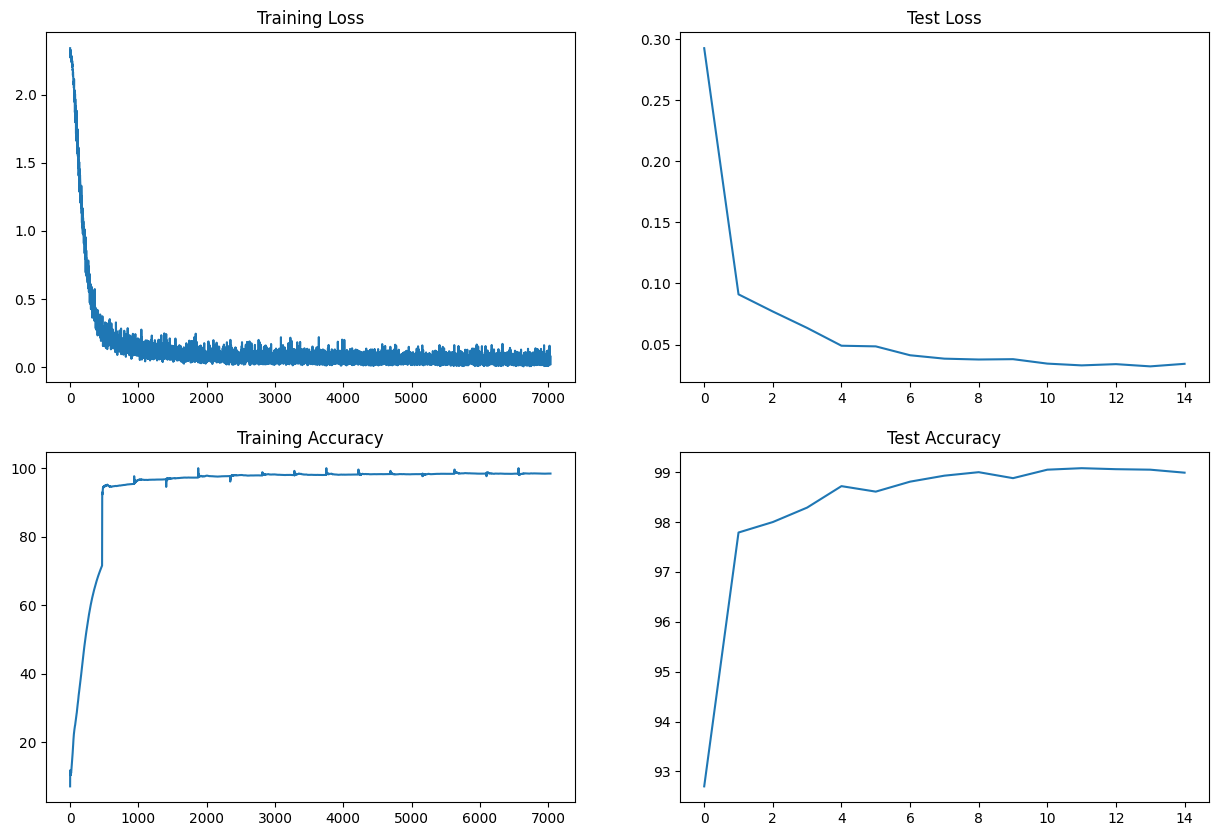

In [14]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")
